<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/VGG16%2CVGG19_UTKFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.applications.vgg19 import preprocess_input,VGG19
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.regularizers import l2
from keras.layers import Dense,Flatten,Dropout

In [3]:
# Define preprocess function for grayscale images
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=-1)
    image = np.repeat(image, 3, axis=-1)  # Convert single channel to 3 channels
    return image

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_group(age):
    return age // 5

In [6]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
image_paths = []
age_labels = []

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    image_path = os.path.join(image_dir, filename)
    image_paths.append(image_path)
    age_labels.append(age)

images = np.array([preprocess_image(img_path) for img_path in image_paths])
age_groups = np.array([age_to_group(age) for age in age_labels])

In [7]:
# Function to convert age group index to interval string
def age_group_to_interval(group_index):
    start = group_index * 5
    end = (group_index + 1) * 5
    return f"{start}-{end}"

In [8]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/part1/28_1_0_20...,25-30
1,/content/drive/MyDrive/Dataset/part1/35_0_0_20...,35-40
2,/content/drive/MyDrive/Dataset/part1/38_0_4_20...,35-40
3,/content/drive/MyDrive/Dataset/part1/50_1_0_20...,50-55
4,/content/drive/MyDrive/Dataset/part1/20_1_2_20...,20-25
5,/content/drive/MyDrive/Dataset/part1/35_0_4_20...,35-40
6,/content/drive/MyDrive/Dataset/part1/57_0_0_20...,55-60
7,/content/drive/MyDrive/Dataset/part1/51_0_0_20...,50-55
8,/content/drive/MyDrive/Dataset/part1/36_1_0_20...,35-40
9,/content/drive/MyDrive/Dataset/part1/39_0_0_20...,35-40


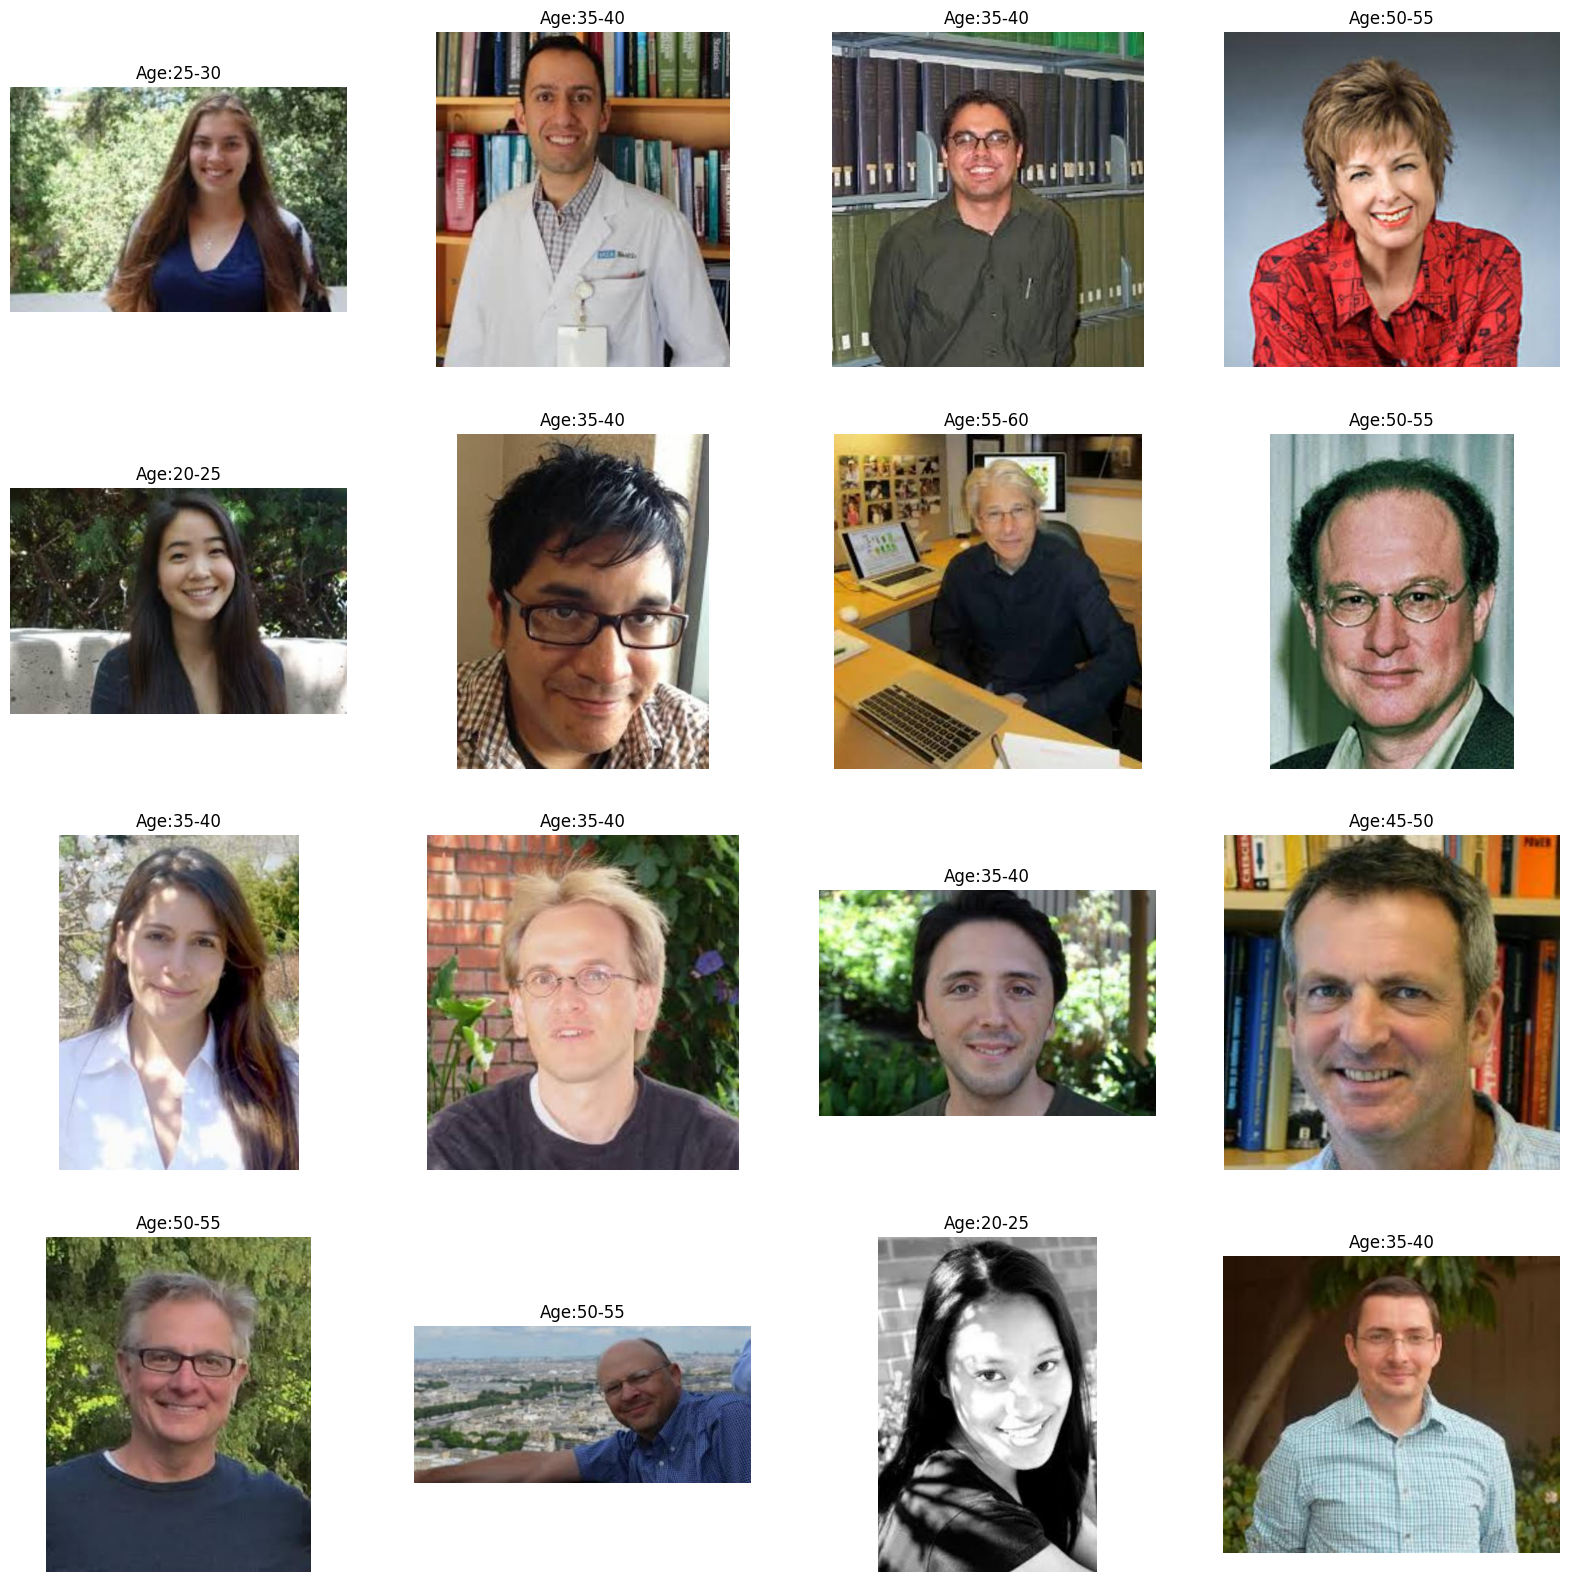

In [9]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

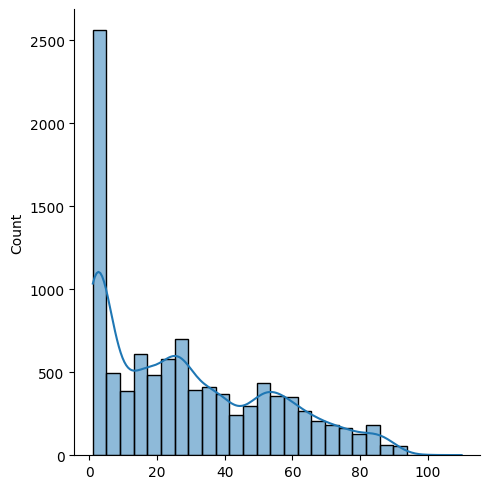

In [10]:
#age distribution
sns.displot(data=age_labels,kde=True)

In [11]:
# Example: Convert age groups to categorical if not already
age_group_indices = [age // 5 for age in age_groups]  # Convert ages to 5-year interval indices
num_classes = np.max(age_groups) + 1
age_groups_categorical = to_categorical(age_groups, num_classes)
print(num_classes)

23


In [12]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_groups_categorical, test_size=0.2, random_state=42)

VGG19

In [13]:
# Load the pre-trained ResNet50 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


VGG16

In [14]:
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [15]:
#Prevent training already trained layers
for layer in base_model.layers:
  layer.trainable = False

In [16]:
# Add custom layers on top of the base model
#Add flatten layer
x = Flatten()(base_model.output)
#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(train_age_groups.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=base_model.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_age_group_model.h5', save_best_only=True, monitor='val_loss')

In [18]:
# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])


In [19]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
199/199 [==============================] - 44s 178ms/step - loss: 4.2138 - accuracy: 0.1884 - val_loss: 3.1371 - val_accuracy: 0.2656
Epoch 2/50
199/199 [==============================] - 28s 142ms/step - loss: 3.0170 - accuracy: 0.2373 - val_loss: 2.8135 - val_accuracy: 0.2907
Epoch 3/50
199/199 [==============================] - 28s 143ms/step - loss: 2.7141 - accuracy: 0.2518 - val_loss: 2.5036 - val_accuracy: 0.2983
Epoch 4/50
199/199 [==============================] - 29s 144ms/step - loss: 2.5904 - accuracy: 0.2650 - val_loss: 2.4556 - val_accuracy: 0.3052
Epoch 5/50
199/199 [==============================] - 29s 144ms/step - loss: 2.5717 - accuracy: 0.2585 - val_loss: 2.4791 - val_accuracy: 0.2826
Epoch 6/50
199/199 [==============================] - 29s 145ms/step - loss: 2.6146 - accuracy: 0.2307 - val_loss: 2.4882 - val_accuracy: 0.2398
Epoch 7/50
199/199 [==============================] - 29s 146ms/step - loss: 2.5591 - accuracy: 0.2341 - val_loss: 2.5170 - val_ac

In [20]:
# Load the best model
model.load_weights('best_age_group_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_age_group_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

In [ ]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

In [ ]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")